# Real data

In [1]:
import os; from os import listdir; from os.path import isfile, join
import re  
#from skimage import io 
from skimage.io import imread
# To manipulate arrays
import numpy as np 
import random
from tqdm.notebook import tqdm
from timeit import default_timer as timer
import scipy
import pandas as pd
import shutil
import pathlib
import sys
import rsnapsim as rss

from skimage.exposure import rescale_intensity
# Plotting
import matplotlib as mpl ; import matplotlib.pyplot as plt 
# To create interactive elements
import ipywidgets as widgets ; from ipywidgets import interact, interactive, fixed, interact_manual, Button, HBox, VBox, Layout, GridspecLayout ; from IPython.display import Image
import dna_features_viewer
from dna_features_viewer import BiopythonTranslator, GraphicFeature, GraphicRecord, CircularGraphicRecord

# Deffining directories
current_dir = pathlib.Path().absolute()
sequences_dir = current_dir.parents[1].joinpath('DataBases','gene_files')
#video_dir = current_dir.parents[1].joinpath('DataBases','LargeDataSets','20190909_u2os_multiplex','smFLAG-KDM5B')
video_dir = current_dir.parents[1].joinpath('DataBases','LargeDataSets','20190909_u2os_multiplex','smFLAG-ActB')

rsnaped_dir = current_dir.parents[1].joinpath('rsnaped')

# Importing rSNAPsim_IP
sys.path.append(str(rsnaped_dir))
import rsnaped as rsp


In [2]:
#Function to detect all tif files in a folder
def folder_reader(folder):
    '''
    This function imports all tif files in a give folder.
    Input:
    folder: str, with the file name.

    Returns:
    list_files_names :  List of str with all file names
    path_files : List of str with all file paths
    '''
    # Reads the folder with the results and import the simulations as lists
    list_files_names = sorted([f for f in listdir(folder) if isfile(join(folder, f)) and ('.tif') in f], key=str.lower)  # reading all tif files in the folder
    list_files_names.sort(key=lambda f: int(re.sub('\D', '', f)))  # sorting the index in numerical order
    path_files = [ str(folder.joinpath(f).resolve()) for f in list_files_names ] # creating the complete path for each file
    # Reading the microscopy data
    
    list_videos = [imread(f)[0:40,:,:,:] for f in  path_files] # List with all the videos. 
    num_videos = len(path_files) # the number of videos in the folder is the length of list_videos
    return path_files, list_files_names,list_videos, num_videos

In [3]:
# Load gene sequences
path_files,list_files_names,list_videos, num_videos = folder_reader(video_dir)
print(path_files)

['/home/luisub/Desktop/rsnaped/DataBases/LargeDataSets/20190909_u2os_multiplex/smFLAG-ActB/MAX_Cell01.tif', '/home/luisub/Desktop/rsnaped/DataBases/LargeDataSets/20190909_u2os_multiplex/smFLAG-ActB/MAX_Cell02.tif']


In [4]:
# Coding sequence
gene_file = str(sequences_dir.joinpath('Bactin_withTags.txt')) # coding sequence for SM_KDM5B_PP7    ### 5685 nt   ### 1895 codons
#gene_file= str(sequences_dir.joinpath('KDM5B_withTags.txt'))  # coding sequence for SM_p300_MS2      ### 8268 nt   ### 2756 codons

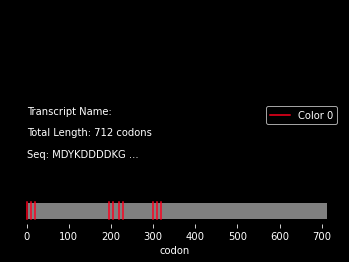

In [5]:
# Simulating a TASEP model for the beta-actin gene
poi_strs, poi_objs, tagged_pois,raw_seq = rss.seqmanip.open_seq_file(gene_file)  #open this file and find all valid protein of interest objs
gene_mrna = tagged_pois['1'][0]  #lets take the first one since thats the longest
rss.solver.protein = gene_mrna #pass this protein object to the solver
gene_mrna.visualize_probe()  # what does our construct look like?

In [6]:
intensity_calculation_method = 'disk_donut'  # options are : 'total_intensity' and 'disk_donut' 'gaussian_fit'
mask_selection_method = 'max_area' # options are : 'max_spots' and 'max_area' 
use_optimization_for_tracking = 0 # 0 not using, 1 is using optimization
#frame_selection_empty_video = 'constant' # Options are: 'constant' , 'shuffle' and 'loop'
#particle_size = 3 # spot size for the simulation and tracking.
particle_detection_size = 5 # spot size for the simulation and tracking.

In [7]:
def plot_original_images(image,slice=0):
    '''
    This function plots all the channels for the original image.
    '''
    number_channels = image.shape[3]
    fig, axes = plt.subplots(nrows=1, ncols=number_channels, figsize=(15, 5))
    for i in range (0,number_channels ):
        img_2d = image[slice,:,:,i]
        img_2d_rescaled = rsp.RemoveExtrema(img_2d, min_percentile = 0.5, max_percentile= 99.5, selected_channels=[0,1]).remove_outliers()
        axes[i].imshow(img_2d_rescaled, cmap='viridis') 
        axes[i].set_title('Channel_'+str(i))
    plt.show()

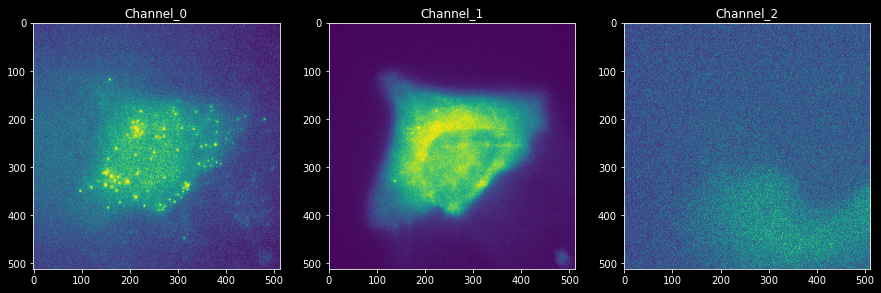

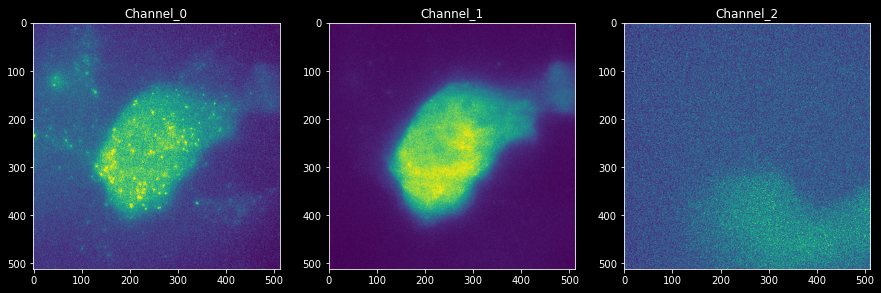

In [8]:
plot_original_images(list_videos[0])
plot_original_images(list_videos[1])

mask time: 6  sec
tracking time: 7  sec
intensity calculation time: 51  sec


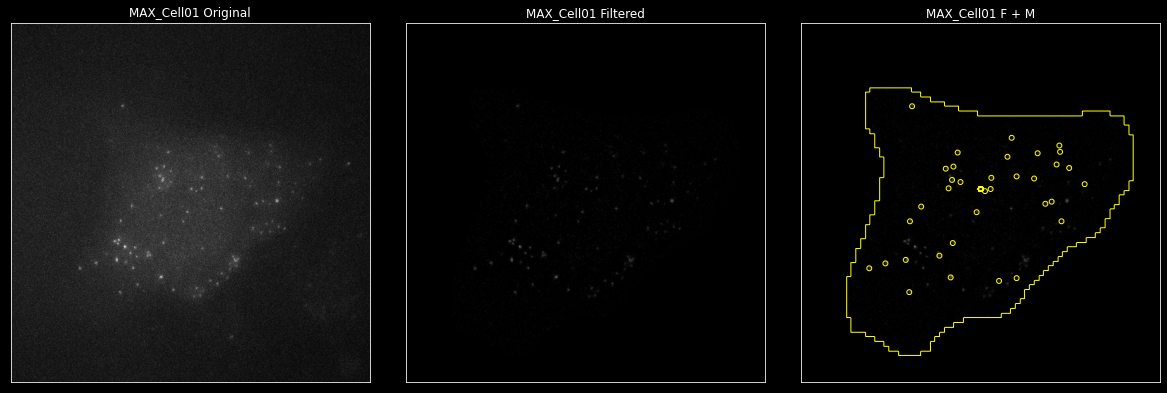

mask time: 4  sec
tracking time: 3  sec
intensity calculation time: 6  sec


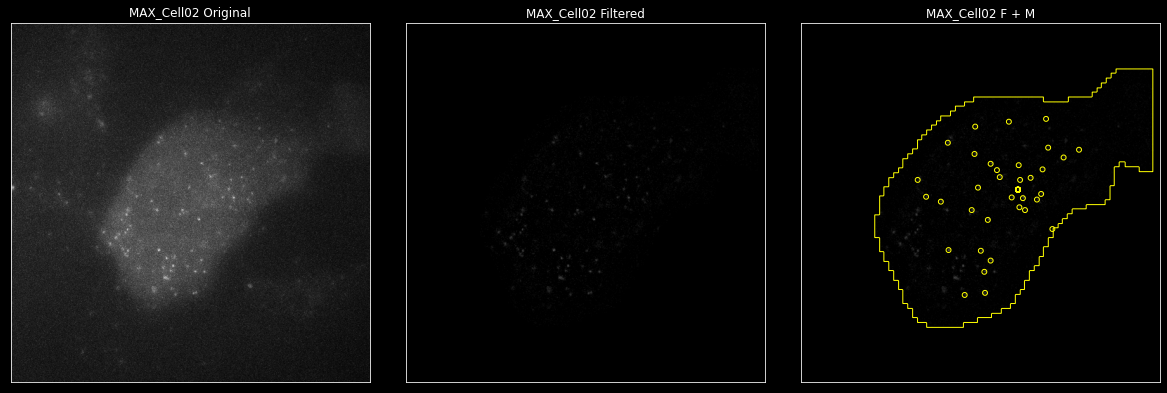

In [9]:
list_DataFrame_particles_intensities= []
for i, temp_video in enumerate(list_videos):
    DataFrame_particles_intensities, _, _, _,_, _, _ = rsp.PipelineTracking(temp_video,particle_size=particle_detection_size,file_name=list_files_names[i],selected_channel=0,intensity_calculation_method =intensity_calculation_method, mask_selection_method = mask_selection_method,show_plot=1,use_optimization_for_tracking=use_optimization_for_tracking,real_positions_dataframe = None, average_cell_diameter=200, print_process_times=1).run()    
    list_DataFrame_particles_intensities.append(DataFrame_particles_intensities)

In [16]:
df =list_DataFrame_particles_intensities[1]
df

,cell_number,particle,frame,red_int_mean,green_int_mean,blue_int_mean,red_int_std,green_int_std,blue_int_std,x,y,SNR_red,SNR_green,SNR_blue,background_int_mean_red,background_int_mean_green,background_int_mean_blue,background_int_std_red,background_int_std_green,background_int_std_blue
0,0,0,0,187.0,321.5,31.5,62.053087,120.270655,17.253684,358.019332,293.143234,18.512821,9.141025,18.008055,701.178589,1010.714294,560.125000,41.113129,113.186432,31.015009
1,0,0,1,200.5,526.5,68.0,62.555575,158.515392,25.728925,358.077457,294.175723,18.254554,8.897595,18.128555,695.178589,1006.767883,563.410706,41.228069,114.920937,30.908144
2,0,0,2,215.5,365.0,96.5,64.797827,120.646034,32.650783,357.736148,293.604222,16.154405,7.831562,21.666868,699.446411,1051.214233,565.071411,46.677052,133.066681,26.034220
3,0,0,3,260.0,355.5,103.5,78.263698,135.608637,25.549951,357.055738,292.590164,15.438784,8.231891,26.710851,714.732117,1082.732178,557.232117,49.190403,131.712143,21.212353
4,0,0,4,242.0,260.0,94.5,75.582538,99.529694,31.208819,358.071272,294.462719,13.434288,8.920818,25.842942,702.839294,1013.446411,565.982117,57.241589,111.962830,21.848906
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1688,0,59,34,443.5,464.0,107.5,102.515294,264.350719,32.257712,232.343036,348.542373,6.098850,11.796824,16.063965,1014.767883,3764.553467,587.053589,161.322220,318.116119,36.479164
1689,0,59,35,456.5,595.0,125.5,141.290906,307.522601,38.064451,228.819511,351.092482,10.097811,13.039189,13.331479,1006.375000,3559.625000,599.500000,108.439346,282.888763,45.138279
1690,0,59,36,618.5,669.5,163.5,179.185383,306.178468,48.357833,227.950769,356.843462,10.592059,13.173628,18.544434,1003.571411,3384.642822,583.035706,104.727509,256.053986,32.063530
1691,0,59,37,116.5,186.5,86.5,48.917073,161.797523,39.370364,226.541398,359.113535,12.681242,11.058166,11.721824,949.517883,3359.410645,599.160706,73.715179,294.175354,50.835091


In [17]:
all_data = True
sel_timepoint = 0

# Intensity vs SNR

slope 0.003496861316395566
intercept 12.880391023857124


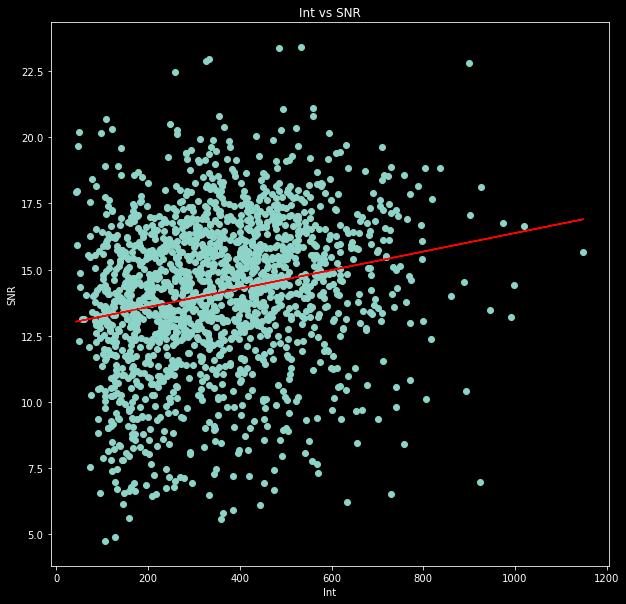

In [18]:
if all_data == True:
    x = df.red_int_mean.values
    y = df.SNR_red.values
else:
    x = df[df['frame'] ==sel_timepoint].red_int_mean.values
    y = df[df['frame'] ==sel_timepoint].SNR_red.values

m, b = np.polyfit(x,y, 1)
print('slope',m)
print('intercept',b)


plt.figure(figsize=(10,10))
plt.scatter(x, y)
plt.plot(x, m*x + b,'-r')
plt.title('Int vs SNR')
plt.ylabel('SNR')
plt.xlabel('Int')
plt.show()

# Intensity vs Noise (mean_background_int)

slope 0.13210459157101984
intercept 851.9961306503307


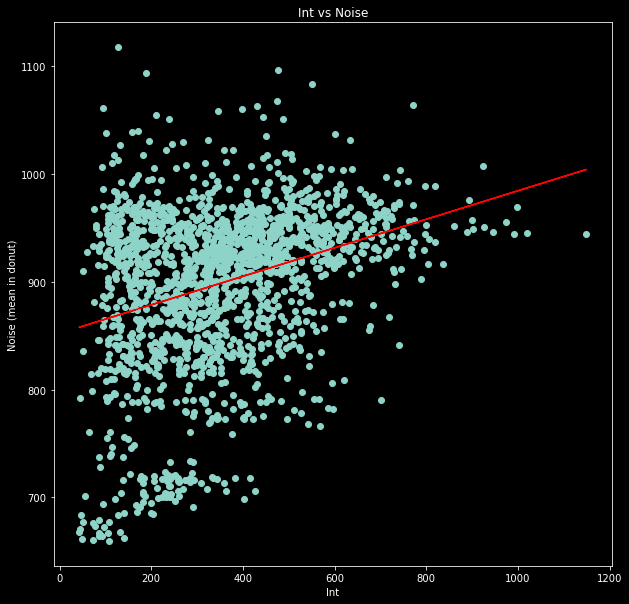

In [19]:
if all_data == True:
    x = df.red_int_mean.values
    y = df.background_int_mean_red.values
else:
    x = df[df['frame'] ==sel_timepoint].red_int_mean.values
    y = df[df['frame'] ==sel_timepoint].background_int_mean_red.values

m, b = np.polyfit(x,y, 1)
print('slope',m)
print('intercept',b)

plt.figure(figsize=(10,10))
plt.scatter(x, y)
plt.plot(x, m*x + b,'-r')
plt.title('Int vs Noise')
plt.ylabel('Noise (mean in donut)')
plt.xlabel('Int')
plt.show()

# SNR vs Noise (mean_background_int)

slope -6.852524755016615
intercept 995.3699416957969


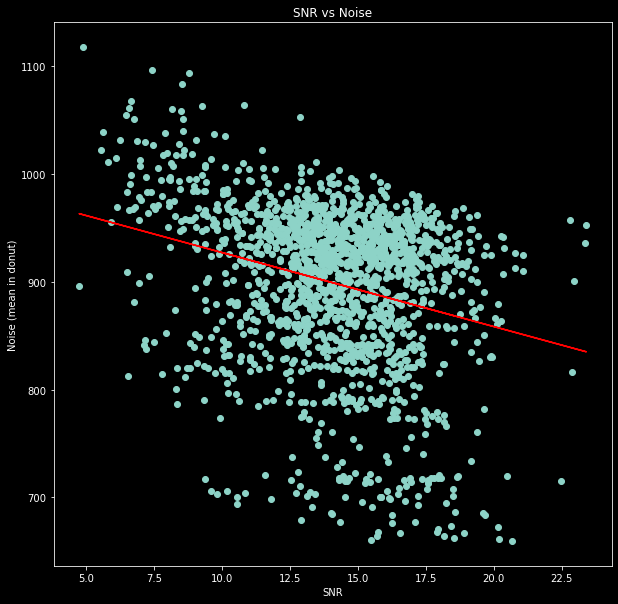

In [20]:
if all_data == True:
    x = df.SNR_red.values
    y = df.background_int_mean_red.values
else:
    x = df[df['frame'] ==sel_timepoint].SNR_red.values
    y = df[df['frame'] ==sel_timepoint].background_int_mean_red.values

m, b = np.polyfit(x,y, 1)
print('slope',m)
print('intercept',b)

plt.figure(figsize=(10,10))
plt.scatter(x, y)
plt.plot(x, m*x + b,'-r')
plt.title('SNR vs Noise')
plt.ylabel('Noise (mean in donut)')
plt.xlabel('SNR')
plt.show()

# BG_Int_std vs SNR 

slope -0.12381220320043408
intercept 23.03575986266051


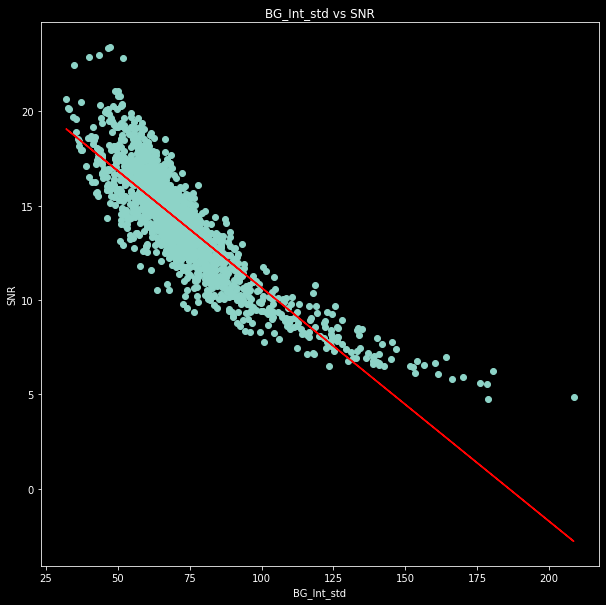

In [21]:
if all_data == True:
    x = df.background_int_std_red.values
    y = df.SNR_red.values
else:
    x = df[df['frame'] ==sel_timepoint].background_int_std_red.values
    y = df[df['frame'] ==sel_timepoint].SNR_red.values

m, b = np.polyfit(x,y, 1)
print('slope',m)
print('intercept',b)

plt.figure(figsize=(10,10))
plt.scatter(x, y)
plt.plot(x, m*x + b,'-r')
plt.title('BG_Int_std vs SNR')
plt.ylabel('SNR')
plt.xlabel('BG_Int_std')
plt.show()

# SNR distribution

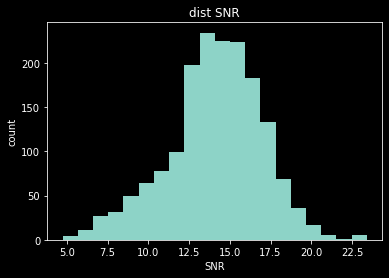

In [24]:
plt.hist(df.SNR_red.values,bins=20)
plt.title('dist SNR')
plt.ylabel('count')
plt.xlabel('SNR')
plt.show()